In [1]:
from main_script import *
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
tvec, data = load_measurements("2008.csv", "forward fill")

In [3]:
tvec

array([[2008.,    1.,    1.,    0.,    0.,    0.],
       [2008.,    1.,    1.,    0.,    1.,    0.],
       [2008.,    1.,    1.,    0.,    2.,    0.],
       ...,
       [2008.,   12.,   31.,   23.,   57.,    0.],
       [2008.,   12.,   31.,   23.,   58.,    0.],
       [2008.,   12.,   31.,   23.,   59.,    0.]])

In [4]:
# tvec[:,-2]

month_idx = []

year, month, day, hour, minute, _ = 

tvec[-1,:] - tvec[0,:]

SyntaxError: invalid syntax (2430645008.py, line 5)

In [ ]:
def aggregate_measurements(tvec, data, period):
    if period == "hour":
        col = 3
    if period == "day":
        col = 2
    if period == "month":
        col = 1
    if period == "hour of the day":
        col = 3
    
    nums = np.unique(tvec[:,col])
    data_a = np.array([])
    tvec_a = np.array([])
    for n in nums:
        tvec_a = np.append(tvec_a, n)

        mask = tvec[:,col] == n
        data_a = np.append(data_a, np.sum(data[mask], axis=0))
    data_a = np.reshape(data_a, (-1,4))
    return tvec_a, data_a, period



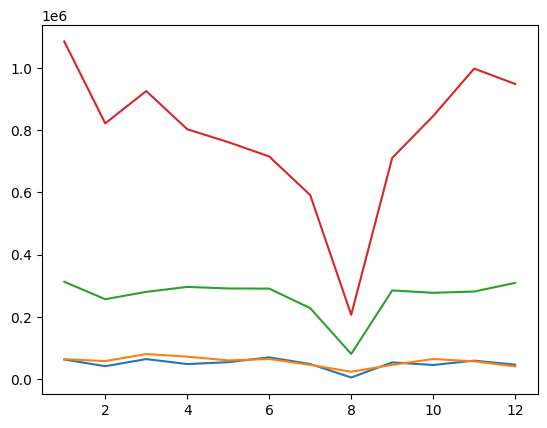

In [ ]:
import matplotlib.pyplot as plt
from main_script import aggregate_measurements

tvec_a, data_a, _ = aggregate_measurements(tvec,data,"month")

for i in range(4):
    plt.plot(tvec_a[:,1],data_a[:,i])

In [ ]:
tvec_a[:23]

array([[ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.],
       [ 0.,  6.,  0.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.,  0.],
       [ 0., 11.,  0.,  0.,  0.,  0.],
       [ 0., 12.,  0.,  0.,  0.,  0.]])